# Bird Classifier using Transfer Learning from MobileNetv2

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [2]:
FILEPATH = '../input/100-bird-species/' # filepath for data
BATCH_SIZE = 32 # keras training batch size
IMAGE_SIZE = (224, 224) # size of images in dataset (keras will resize)
MOBILE_NET_TRAINABLE_LAYERS = 3 # layers at end of the mobile_net base model to have trainable parameters

SEED = 6278 # random seed for repeatability of notebook

In [3]:
# Training Dataset
train = image_dataset_from_directory(directory = FILEPATH + 'train/',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)

# Validation Dataset
valid = image_dataset_from_directory(directory = FILEPATH + 'valid/',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)

Found 70626 files belonging to 450 classes.


2022-11-17 04:35:39.924471: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 2250 files belonging to 450 classes.


2022-11-17 04:35:40.796642: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


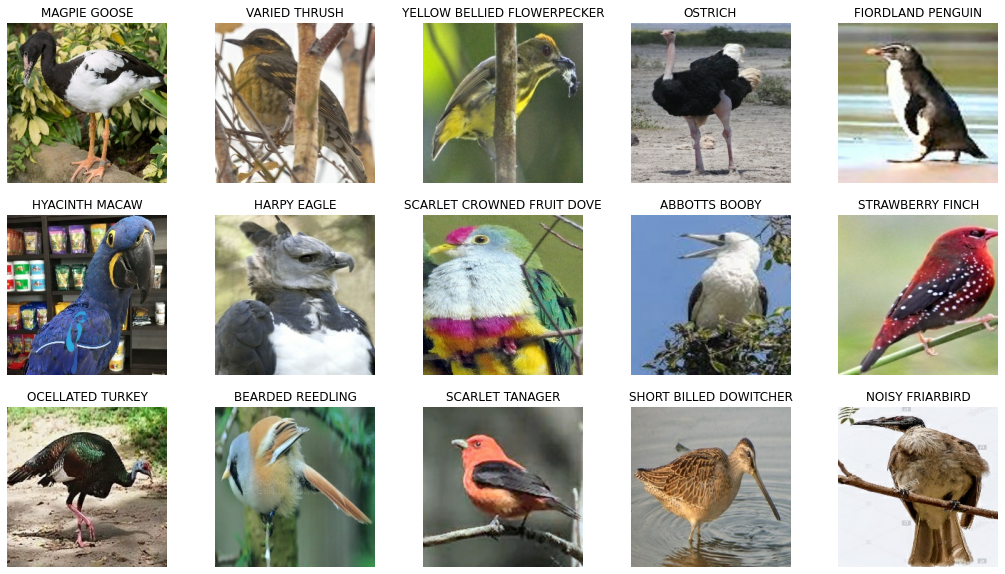

In [4]:
class_names = train.class_names

plt.figure(figsize=(18, 10))

for images, labels in train.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

# Data Augmentation

In [5]:
def data_augmentor(h_flip=True, v_flip=False, rotate=True,):
    
    augmentor = Sequential() # Create returned Sequential class.
    augmentor.add(layers.Rescaling(1./255)) # Rescale image values from 0 - 255 to 0 - 1.

    # Based on function arguments: perform random flipping
    if h_flip and v_flip:
        augmentor.add(layers.RandomFlip('horizontal_and_vertical'))
    elif h_flip:
        augmentor.add(layers.RandomFlip('horizontal'))
    elif v_flip:
        augmentor.add(layers.RandomFlip('vertical'))

    # Based on function arguments: perform random rotation    
    if rotate:
        augmentor.add(layers.RandomRotation(0.2))
    
    return augmentor

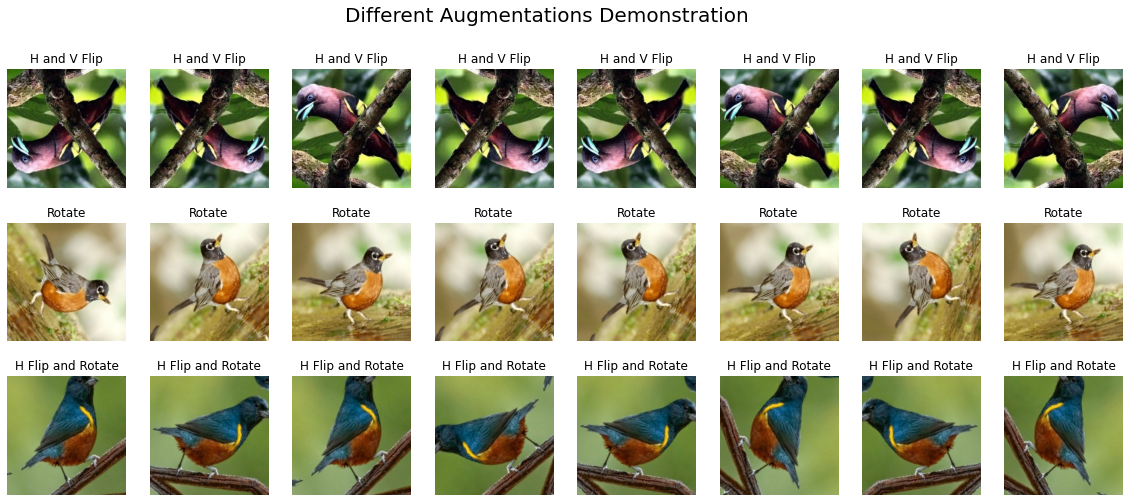

In [6]:
augmentor1 = data_augmentor(h_flip = True, v_flip = True, rotate=False)
augmentor2 = data_augmentor(h_flip = False, v_flip = False, rotate=True)
augmentor3 = data_augmentor(h_flip = True, v_flip = False, rotate=True)

augs = [augmentor1, augmentor2, augmentor3]

details = ['H and V Flip',
           'Rotate',
           'H Flip and Rotate']

plt.figure(figsize=(20, 8))
for images, labels in train.take(1):
    for i, aug in enumerate(augs):
        img = images[i]
        for j in range(8):
            ax = plt.subplot(3, 8, (i*8 + j + 1))
            img_augmented = aug(tf.expand_dims(img, 0))
            plt.imshow(img_augmented[0])
            plt.axis('off')
            ax.set_title(details[i])
            
plt.suptitle('Different Augmentations Demonstration', fontsize=20);

# Import MobileNetV2 Base Model

In [7]:
IMAGE_SHAPE = IMAGE_SIZE + (3,)

mobile_base = MobileNetV2(input_shape = IMAGE_SHAPE,
                          include_top = False,
                          weights = 'imagenet')

mn_layers = len(mobile_base.layers)

9420800/9406464 [==============================] - 0s 0us/step


In [8]:
mobile_base.trainable = True

print('Setting the last {} layers in the Mobile Net Base Model to trainable!'.format(MOBILE_NET_TRAINABLE_LAYERS))

for mn_layer in mobile_base.layers[:-MOBILE_NET_TRAINABLE_LAYERS]:
    mn_layer.trainable = False

Setting the last 3 layers in the Mobile Net Base Model to trainable!


# Build Model
## Augmentor &rarr; Mobile Net V2 Base &rarr; Dense Classifier Layers

In [9]:
# start model with input shape equal to image shape
inputs = tf.keras.Input(shape = IMAGE_SHAPE)
# apply h-flip and rotation data augmentation
x = augmentor3(inputs)
# apply through mobile net v2 base
x = mobile_base(x)
# global average pool to collapse to 1D
x = layers.GlobalAveragePooling2D()(x) 
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.2)(x)
# densely connected layer with 2000
x = layers.Dense(1200, activation='relu')(x) 
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.2)(x)
# densely connected layer with 1000
x = layers.Dense(900, activation='relu')(x) 
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.2)(x)
# densely connected output layer with same number of output classes
outputs = layers.Dense(450, activation='softmax')(x) 
        
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1200)              1537200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1200)              0     

In [10]:
LEARNING_RATE = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model.compile(optimizer = optimizer,
              loss = loss,
              metrics=['accuracy'])

In [11]:
initial_epochs = 5
history = model.fit(train, validation_data=valid, epochs=initial_epochs)

Epoch 1/5
2208/2208 [==============================] - 1026s 462ms/step - loss: 2.7029 - accuracy: 0.3822 - val_loss: 1.1448 - val_accuracy: 0.6804
Epoch 2/5
2208/2208 [==============================] - 1015s 459ms/step - loss: 1.6627 - accuracy: 0.5747 - val_loss: 0.7743 - val_accuracy: 0.7809
Epoch 3/5
2208/2208 [==============================] - 1023s 463ms/step - loss: 1.4500 - accuracy: 0.6271 - val_loss: 0.6790 - val_accuracy: 0.8027
Epoch 4/5
2208/2208 [==============================] - 1026s 464ms/step - loss: 1.3161 - accuracy: 0.6570 - val_loss: 0.6336 - val_accuracy: 0.8236
Epoch 5/5
2208/2208 [==============================] - 1025s 464ms/step - loss: 1.2326 - accuracy: 0.6776 - val_loss: 0.5665 - val_accuracy: 0.8320


In [12]:
model.save('./Bird Classifier')
model.save('./Bird Classifier.h5')
model.save_weights("./Bird Classifer Weights.h5")

2022-11-17 06:02:18.669605: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
